# **Copy Move Image Classification with ELA(Error Level Analysis) and CNN**


## import necessary libraries

In [3]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [3]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

# Open a real image

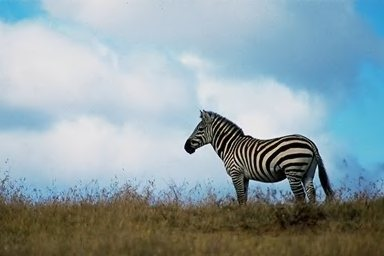

In [4]:
real_image_path = 'CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

# After converting to ELA image

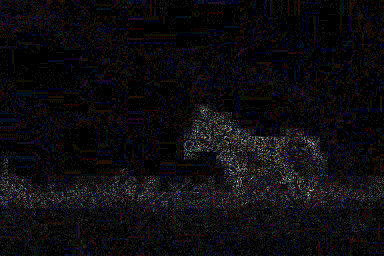

In [5]:
convert_to_ela_image(real_image_path, 90)

# Open a fake image

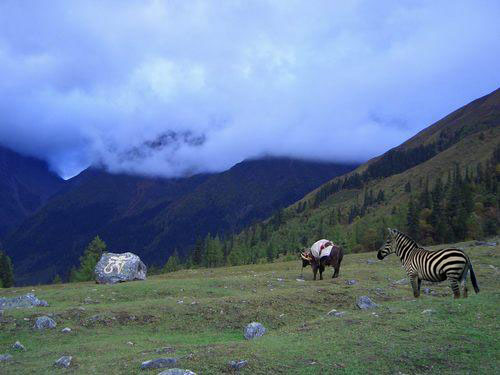

In [6]:
fake_image_path = 'CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
Image.open(fake_image_path)

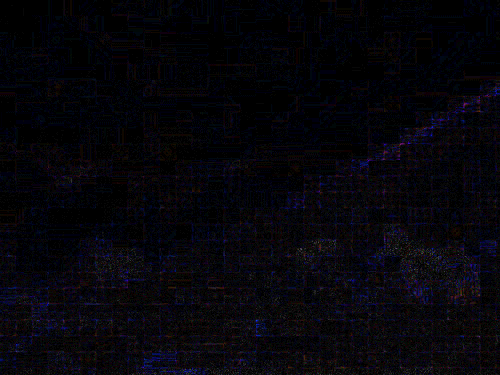

In [7]:
convert_to_ela_image(fake_image_path, 90)

# Dataset Preparation

In [8]:
image_size = (128, 128)

In [9]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [10]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

## Au => Total Images 7354, Take 2100 random images from the list
## Tp => Total Images 2064

In [11]:
import random
path = 'CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [12]:
path = 'CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


## Visualize The Images

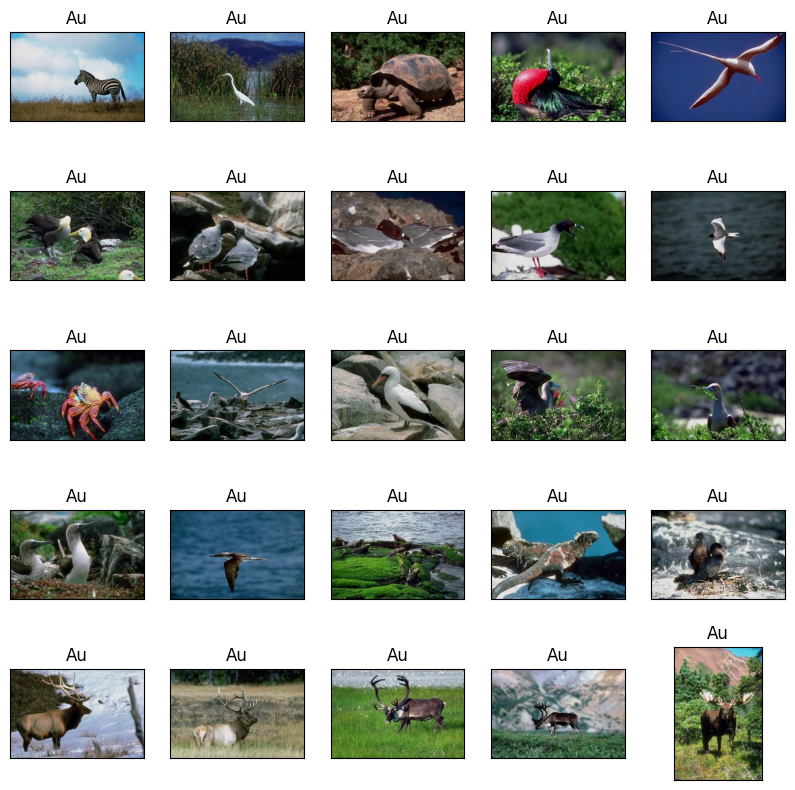

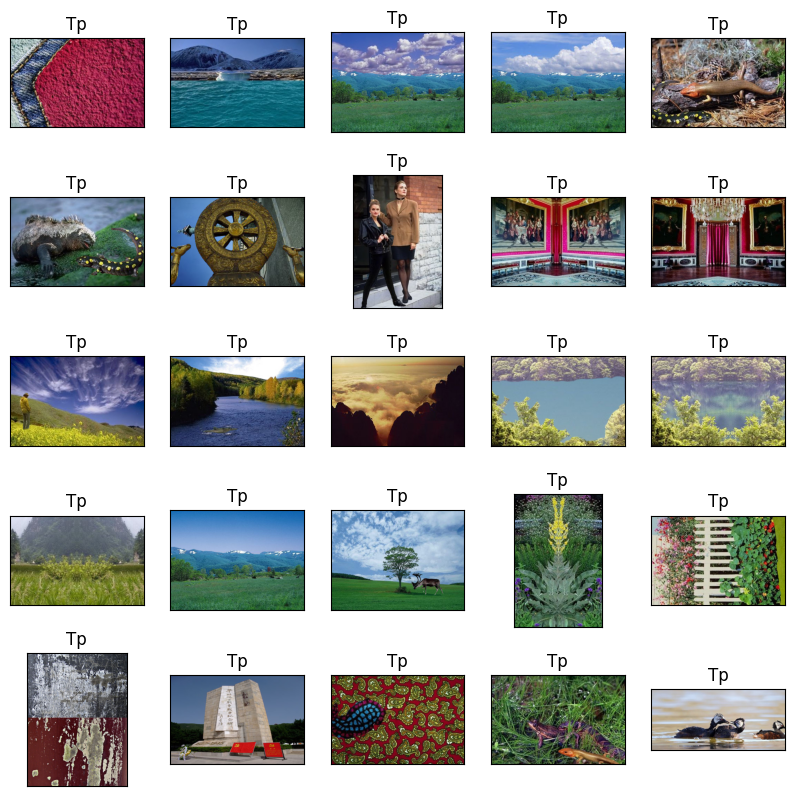

In [24]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the prepare_image function
def prepare_image(image_path):
    try:
        # Open an image file
        with Image.open(image_path) as img:
            # Perform image resizing or other necessary preprocessing here
            # For this example, we'll just convert the image to a numpy array
            return np.array(img)
    except IOError:
        print(f"Error in reading image: {image_path}")
        return None

# Step 2: Load images and prepare them
def load_images(path, image_count=25):
    image_list = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                full_path = os.path.join(dirname, filename)
                image = prepare_image(full_path)
                if image is not None:
                    image_list.append(image)
                    if len(image_list) == image_count:
                        break
        if len(image_list) == image_count:
            break
    return image_list

# Step 3: Define the plot_images function (as modified in the previous message)
def plot_images(image_list, title):
    plt.figure(figsize=(10, 10))
    for i in range(len(image_list)):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        image = image_list[i]
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.title(title)
    plt.show()

# Step 4: Load and plot images
au_images = load_images('CASIA2/Au/')
tp_images = load_images('CASIA2/Tp/')

# Step 5: Call plot_images to display the images
plot_images(au_images, "Au")
plot_images(tp_images, "Tp")


# One Hot Encoding to Categorical

In [25]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

# Train Test split with 80:20 ratio

In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


# Custom CNN Model

In [1]:
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
def build_upgraded_model(input_shape=(128, 128, 3)):
    model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),

    # Convolutional Block 1
    layers.Conv2D(32, (5, 5), padding='valid', activation='relu'),
    layers.BatchNormalization(),

    # Convolutional Block 2
    layers.Conv2D(64, (5, 5), padding='valid', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), padding='valid', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Flattening and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(2, activation='softmax')
    ])
    return model
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [2]:
model = build_upgraded_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      51264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                        

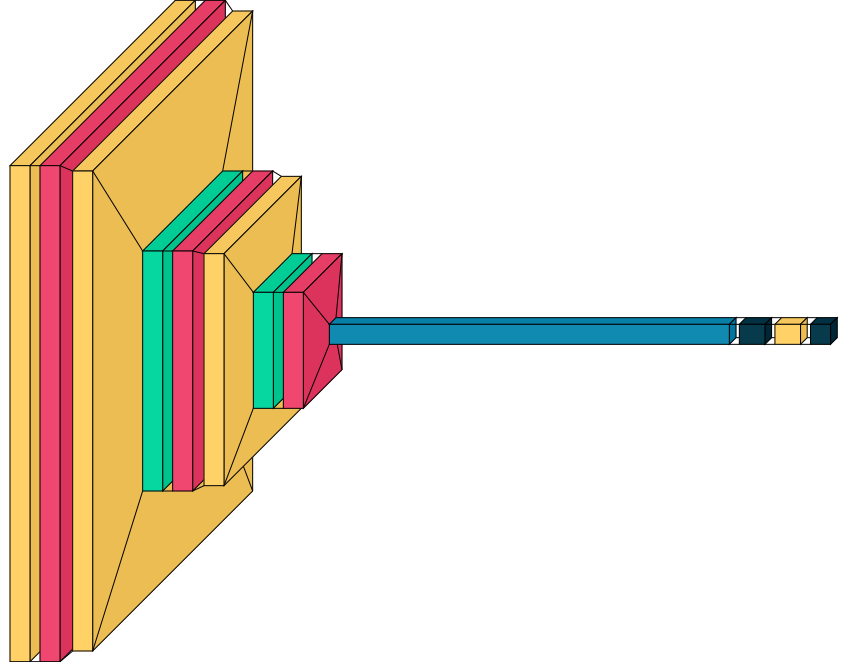

In [4]:
import visualkeras
visualkeras.layered_view(model)

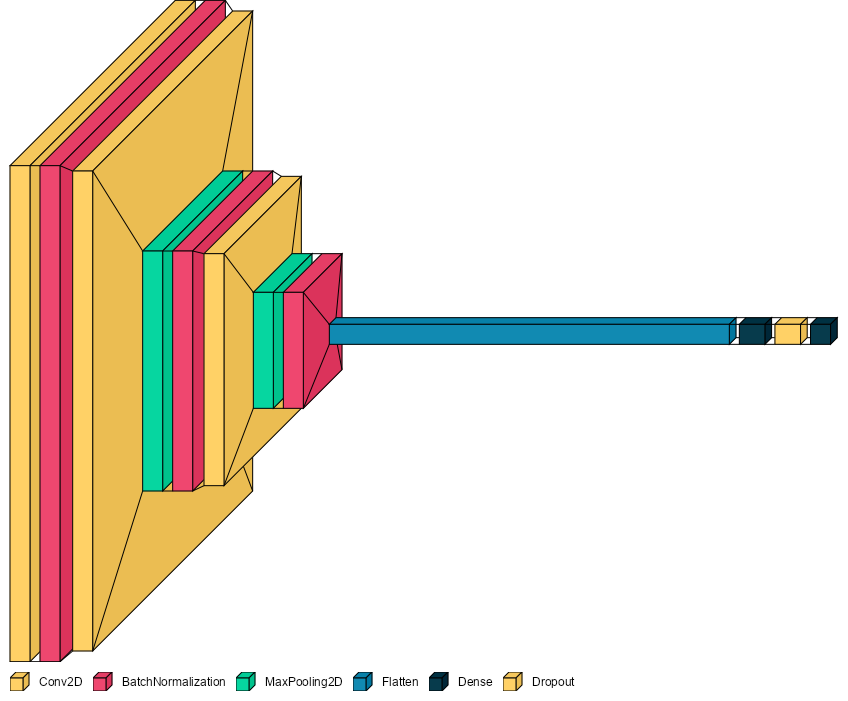

In [5]:
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font) # selected font

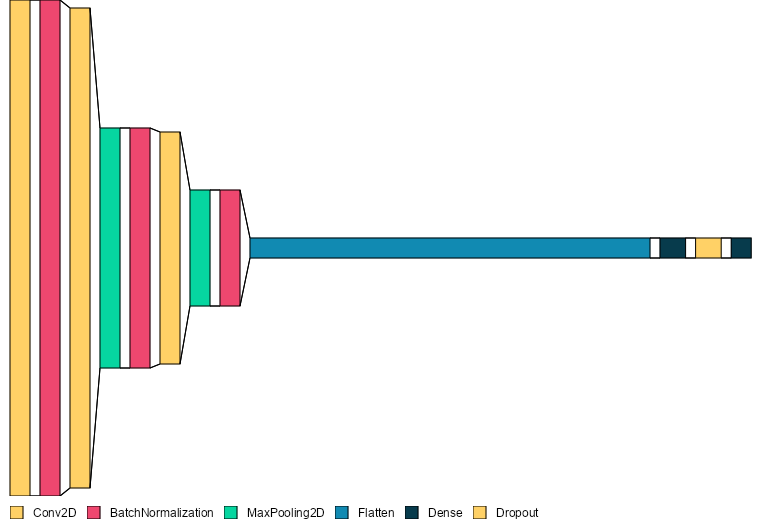

In [6]:
visualkeras.layered_view(model, legend=True, font=font, draw_volume=False)


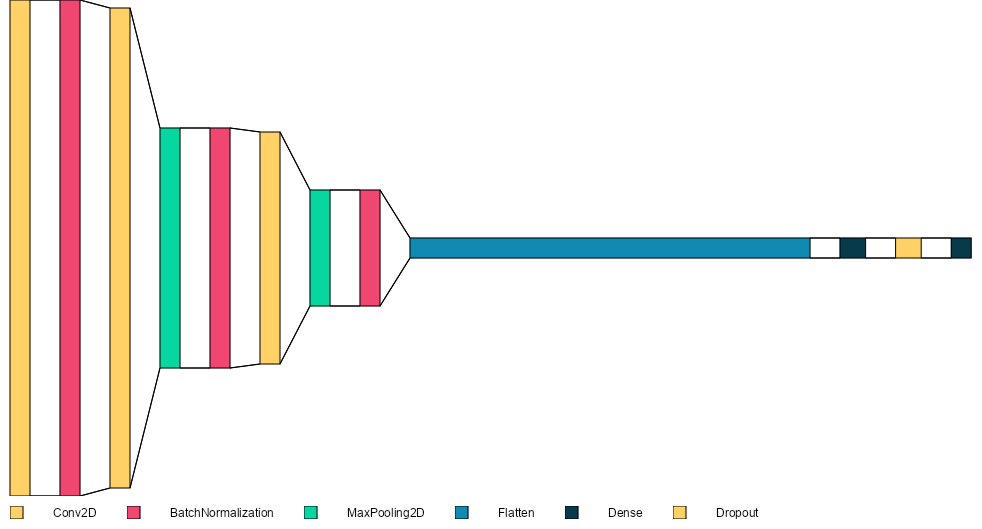

In [7]:
visualkeras.layered_view(model, legend=True, font=font, draw_volume=False,spacing=30)


In [14]:
from keras.utils.vis_utils import pydot
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Hyperparameters Setting

In [49]:
epochs = 30
batch_size = 32


In [50]:
# Define custom metrics
precision = Precision(name='precision')
recall = Recall(name='recall')

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

## Optimizer

In [51]:
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

C:\Users\Nawaz\anaconda3\envs\media\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [53]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', precision, recall, f1_score])

In [54]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

## Model Training

In [55]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
105/105 [==============================] - 3s 21ms/step - loss: 0.5014 - accuracy: 0.7604 - precision: 0.7604 - recall: 0.7604 - f1_score: 0.6479 - val_loss: 0.3190 - val_accuracy: 0.8956 - val_precision: 0.8956 - val_recall: 0.8956 - val_f1_score: 0.8900
Epoch 2/30
105/105 [==============================] - 2s 17ms/step - loss: 0.3237 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8940 - f1_score: 0.8980 - val_loss: 0.2696 - val_accuracy: 0.9172 - val_precision: 0.9172 - val_recall: 0.9172 - val_f1_score: 0.9135
Epoch 3/30
105/105 [==============================] - 2s 17ms/step - loss: 0.2887 - accuracy: 0.9048 - precision: 0.9048 - recall: 0.9048 - f1_score: 0.9020 - val_loss: 0.2485 - val_accuracy: 0.9196 - val_precision: 0.9196 - val_recall: 0.9196 - val_f1_score: 0.9091
Epoch 4/30
105/105 [==============================] - 2s 17ms/step - loss: 0.2618 - accuracy: 0.9105 - precision: 0.9105 - recall: 0.9105 - f1_score: 0.9132 - val_loss: 0.2341 - val_accuracy: 0.9136 

105/105 [==============================] - 2s 17ms/step - loss: 0.0453 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - f1_score: 0.9843 - val_loss: 0.1882 - val_accuracy: 0.9364 - val_precision: 0.9364 - val_recall: 0.9364 - val_f1_score: 0.9332
Epoch 28/30
105/105 [==============================] - 2s 17ms/step - loss: 0.0358 - accuracy: 0.9874 - precision: 0.9874 - recall: 0.9874 - f1_score: 0.9877 - val_loss: 0.1933 - val_accuracy: 0.9364 - val_precision: 0.9364 - val_recall: 0.9364 - val_f1_score: 0.9332
Epoch 29/30
105/105 [==============================] - 2s 17ms/step - loss: 0.0335 - accuracy: 0.9916 - precision: 0.9916 - recall: 0.9916 - f1_score: 0.9918 - val_loss: 0.1986 - val_accuracy: 0.9352 - val_precision: 0.9352 - val_recall: 0.9352 - val_f1_score: 0.9336
Epoch 30/30
105/105 [==============================] - 2s 17ms/step - loss: 0.0318 - accuracy: 0.9898 - precision: 0.9898 - recall: 0.9898 - f1_score: 0.9882 - val_loss: 0.2172 - val_accuracy: 0.9340 - val_pr

## Model Export

In [56]:
model.save('model_casia_run_hamad.h5')

## Training Model Graphs Acc, Loss

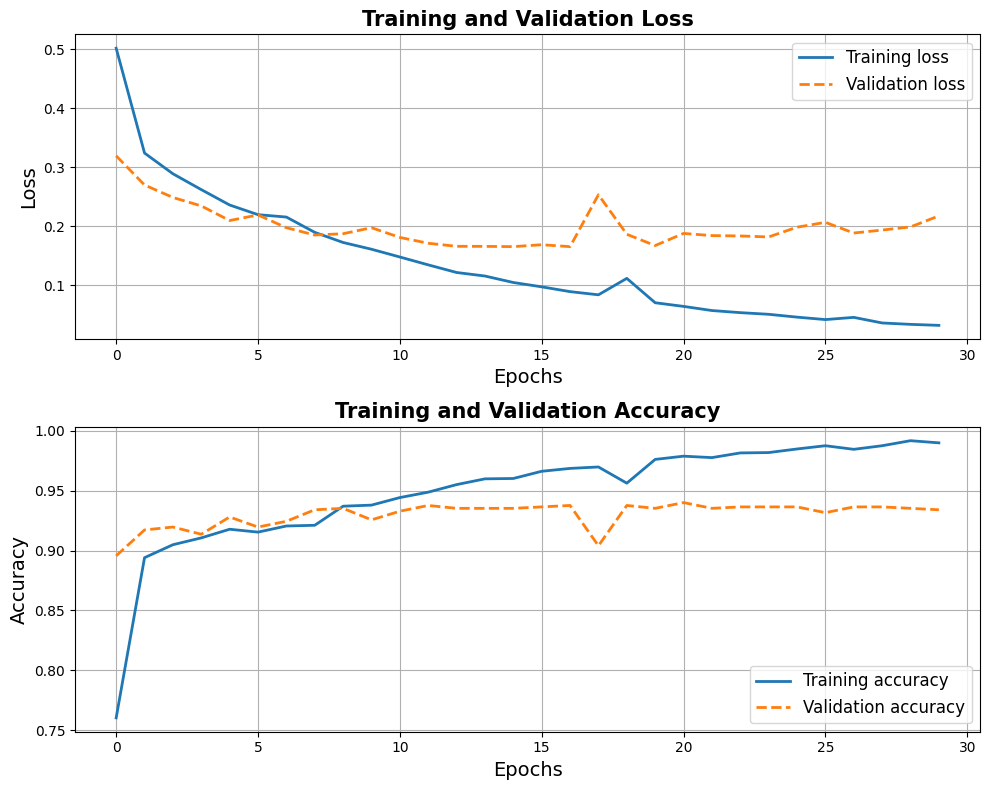

In [57]:
import matplotlib.pyplot as plt

# Set a consistent color palette
colors = {
    'train': '#1f77b4',  # blue
    'val': '#ff7f0e'     # orange
}

fig, ax = plt.subplots(2, 1, figsize=(10, 8))  # Adjusted the figure size

# Training and validation loss
ax[0].plot(hist.history['loss'], color=colors['train'], label="Training loss", linewidth=2)
ax[0].plot(hist.history['val_loss'], color=colors['val'], label="Validation loss", linewidth=2, linestyle='--')
ax[0].set_title('Training and Validation Loss', fontweight='bold', fontsize=15)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(loc='upper right', fontsize=12)
ax[0].grid(True)

# Training and validation accuracy
ax[1].plot(hist.history['accuracy'], color=colors['train'], label="Training accuracy", linewidth=2)
ax[1].plot(hist.history['val_accuracy'], color=colors['val'], label="Validation accuracy", linewidth=2, linestyle='--')
ax[1].set_title('Training and Validation Accuracy', fontweight='bold', fontsize=15)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(loc='lower right', fontsize=12)
ax[1].grid(True)

plt.tight_layout()  # Adjust the spacing between plots
plt.show()


## Training Model Graphs Precision, Recall, F1-Score

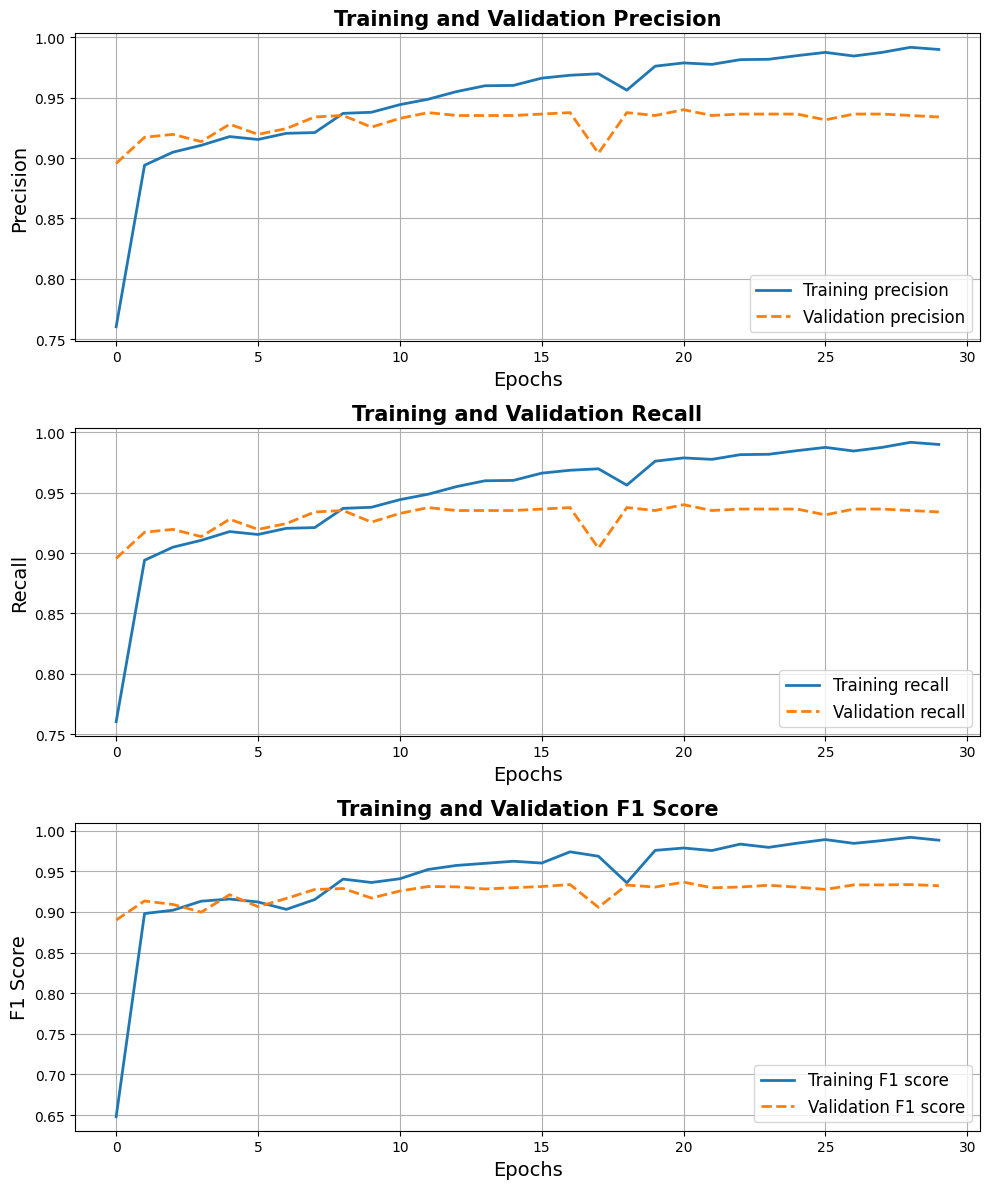

In [59]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Training and validation precision
ax[0].plot(hist.history['precision'], color=colors['train'], label="Training precision", linewidth=2)
ax[0].plot(hist.history['val_precision'], color=colors['val'], label="Validation precision", linewidth=2, linestyle='--')
ax[0].set_title('Training and Validation Precision', fontweight='bold', fontsize=15)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Precision', fontsize=14)
ax[0].legend(loc='lower right', fontsize=12)
ax[0].grid(True)

# Training and validation recall
ax[1].plot(hist.history['recall'], color=colors['train'], label="Training recall", linewidth=2)
ax[1].plot(hist.history['val_recall'], color=colors['val'], label="Validation recall", linewidth=2, linestyle='--')
ax[1].set_title('Training and Validation Recall', fontweight='bold', fontsize=15)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Recall', fontsize=14)
ax[1].legend(loc='lower right', fontsize=12)
ax[1].grid(True)

# Training and validation F1-score
ax[2].plot(hist.history['f1_score'], color=colors['train'], label="Training F1 score", linewidth=2)
ax[2].plot(hist.history['val_f1_score'], color=colors['val'], label="Validation F1 score", linewidth=2, linestyle='--')
ax[2].set_title('Training and Validation F1 Score', fontweight='bold', fontsize=15)
ax[2].set_xlabel('Epochs', fontsize=14)
ax[2].set_ylabel('F1 Score', fontsize=14)
ax[2].legend(loc='lower right', fontsize=12)
ax[2].grid(True)

plt.tight_layout()
plt.show()


# Predict on Test Results

27/27 [==============================] - 0s 13ms/step
Metric         Score     
-------------------------
Precision      0.95      
Recall         0.92      
F1 Score       0.93      
Accuracy       0.93      


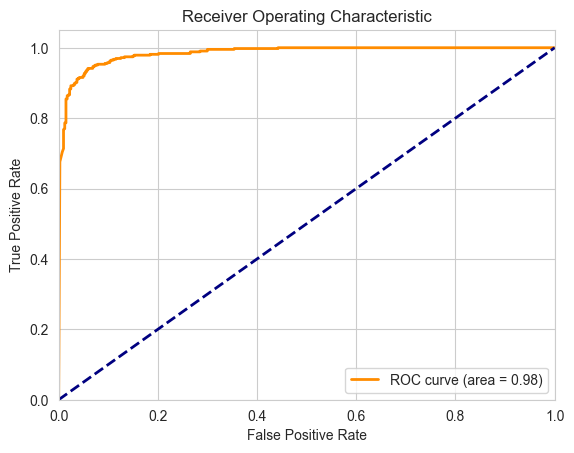

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def display_results(model, X_val, Y_val):
    
    # Get predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(Y_val, axis=1)
    
    # Calculate precision, recall, F1 score and accuracy
    precision = precision_score(y_true_classes, y_pred_classes)
    recall = recall_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes)
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    
    # Print the metrics
    print(f"{'Metric':<15}{'Score':<10}")
    print(f"{'-'*25}")
    print(f"{'Precision':<15}{precision:<10.2f}")
    print(f"{'Recall':<15}{recall:<10.2f}")
    print(f"{'F1 Score':<15}{f1:<10.2f}")
    print(f"{'Accuracy':<15}{accuracy:<10.2f}")
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    sns.set_style("whitegrid")
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Use the function to display the results
display_results(model, X_val, Y_val)



## ROC for the trained Model on Test Data

27/27 [==============================] - 0s 15ms/step


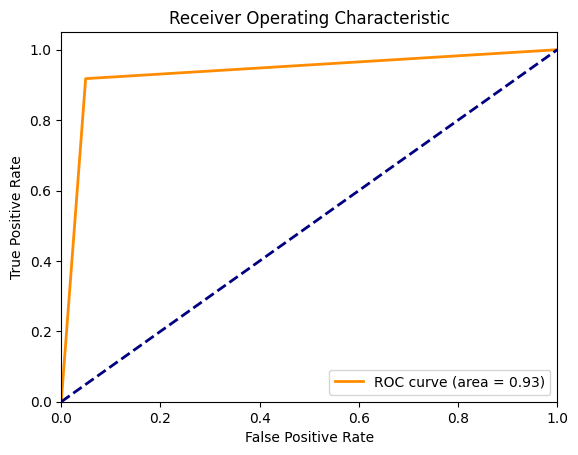

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test is your test labels and model is your trained model
y_pred = model.predict(X_val)
y_true = np.argmax(Y_val, axis=1)
y_score = np.argmax(y_pred, axis=1)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Confusion Matrix for the Test Data

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    


27/27 [==============================] - 0s 13ms/step


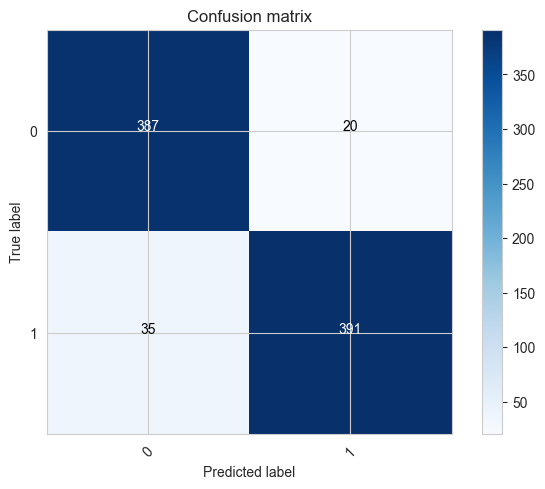

In [66]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

# Testing on New Image

In [67]:
class_names = ['Forgery', 'Real']

In [103]:
from tensorflow.keras.preprocessing import image

def prepare_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the pixel values
    return img_array


1/1 [==============================] - 0s 47ms/step
Prediction array:  [[0. 1.]]


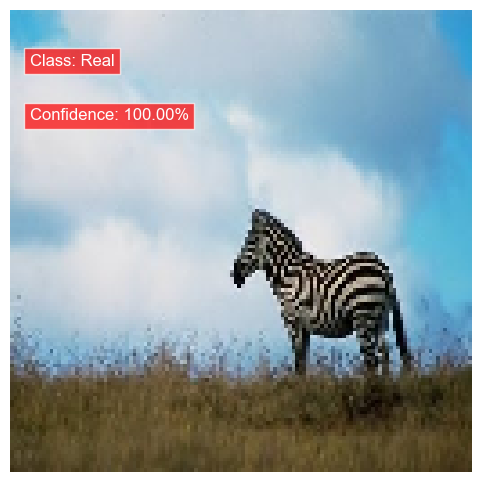

In [92]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Define the custom metric function (replace with your actual f1_score function)
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Load the saved model with custom objects
model = load_model('model_casia_run_hamad.h5', custom_objects={'f1_score': f1_score})

# Function to prepare the image
def prepare_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the pixel values
    return img_array

# Class names
class_names = ['Forgery', 'Real']

# Image path (replace with your image path)
real_image_path = 'CASIA2/Au/Au_ani_00001.jpg'

# Prepare the image and make predictions
image = prepare_image(real_image_path)
image_for_model = np.expand_dims(image, axis=0)
y_pred = model.predict(image_for_model)
y_pred_class = np.argmax(y_pred, axis=1)[0]

# Print the prediction array to console
print("Prediction array: ", y_pred)

# Display the image with predictions
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')

# Get the confidence score
confidence = y_pred[0][y_pred_class] * 100

# Overlay the predicted class and confidence score
plt.text(5, 15, f"Class: {class_names[y_pred_class]}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.7))
plt.text(5, 30, f"Confidence: {confidence:.2f}%", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.7))

plt.show()


In [105]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [94]:
class_names = ['fake', 'real']
real_image_path = 'CASIA2/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 15ms/step
Class: real Confidence: 100.00


In [95]:
fake_image_path = 'CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 15ms/step
Class: fake Confidence: 99.87


In [108]:
fake_image = os.listdir('CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 99.98
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.96
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 21ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 26ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Clas

1/1 [==============================] - 0s 21ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 13ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 13ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 13ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 99.70
1/1 [==============================] - 0s 14ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Cla

1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Cl

1/1 [==============================] - 0s 14ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.99
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 99.97
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 95.33
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 24ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Class

Class: Forgery Confidence: 93.51
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 25ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 18ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Class: Forgery Confidence: 100.00
1/1 [================

1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.33
1/1 [==============================] - 0s 20ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 99.84
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 97.64
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 99.98
1/1 [==============================] - 0s 21ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 13ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.84
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 99.76
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 22ms/step
Class: F

1/1 [==============================] - 0s 18ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 24ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 10ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Cl

1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.53
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 18ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Cla

1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 99.99
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 13ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 20ms/step
Cla

1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 55.82
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.86
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 99.92
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 3ms/step
Class:

1/1 [==============================] - 0s 12ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 99.99
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.56
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.18
1/1 [==============================] - 0s 13ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 99.99
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 99.99
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: 

Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 13ms/step
Class: Forgery Confidence: 99.96
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.83
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [=================

1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 14ms/step
Cl

1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.99
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.99
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 15ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 99.08
1/1 [==============================] - 0s 16ms/step
Class: Forgery Confidence: 100.00
1/1 [==============================] - 0s 17ms/step
Class

In [109]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 2040, Acc: 98.83720930232558


In [111]:
real_image = os.listdir('CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('CASIA2/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


In [112]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 6864, Acc: 93.3369594778352
Total: 9418, Correct: 8904, Acc: 94.54236568273518


In [1]:
# class_names = ['Fake Image', 'Real Image']
# folder="/kaggle/input/casia-dataset/"
# paths=glob.glob(folder+"*/*/*.jpg")
# paths.append(glob.glob(folder+"*.png"))

In [2]:
# path=random.choice(paths)

# plt.imshow(Image.open(path))
# plt.axis('off')
# image = prepare_image(path)
# image = image.reshape(-1, 128, 128, 3)
# y_pred = model.predict(image)
# y_pred_class = np.argmax(y_pred, axis = 1)[0]
# y_true="Real Image" if ('Au' in path) else "Fake Image"

# print("\n\n")
# print(f'File Name: {path}')
# print(f'Confidence: {np.amax(y_pred) * 100:0.2f}')
# print(f'Predicted Class: {class_names[y_pred_class]}')
# print(f'Actual Class: {y_true}')

In [100]:
# class_names = ['Forgery', 'Real']
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming the prepare_image function loads and preprocesses the image
# real_image_path = 'CASIA2/Au/Au_ani_00001.jpg'
# image = prepare_image(real_image_path)
# image_for_model = np.expand_dims(image, axis=0)  # reshaping for the model input

# y_pred = model.predict(image_for_model)
# y_pred_class = np.argmax(y_pred, axis=1)[0]

# # Display the image using matplotlib
# plt.figure(figsize=(8, 6))  # adjust the figure size
# plt.imshow(image)
# plt.axis('off')  # turn off axis numbers and ticks

# # Overlay the predicted class and confidence level on the image
# confidence = y_pred[0][y_pred_class] * 100  # Corrected this line to get the confidence of the predicted class
# plt.text(5, 15, f"Class: {np.amax(y_pred) * 100:0.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.7))
# plt.text(5, 30, f"Confidence: {confidence:.2f}%", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.7))

# plt.show()


In [101]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras import backend as K

# # Define the custom metric function (replace with your actual f1_score function)
# def f1_score(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

# # Load the saved model with custom objects
# model = load_model('model_casia_run_hamad.h5', custom_objects={'f1_score': f1_score})

# # Function to prepare the image
# def prepare_image(image_path):
#     img = image.load_img(image_path, target_size=(128, 128))
#     img_array = image.img_to_array(img)
#     img_array = img_array / 255.0  # Normalize the pixel values
#     return img_array

# # Class names
# class_names = ['Forgery', 'Real']

# # Image path (replace with your image path)
# real_image_path = '/mnt/data/download.png'

# # Prepare the image and make predictions
# image = prepare_image(real_image_path)
# image_for_model = np.expand_dims(image, axis=0)
# y_pred = model.predict(image_for_model)
# y_pred_class = np.argmax(y_pred, axis=1)[0]

# # Print the prediction array to console
# print("Prediction array: ", y_pred)

# # Display the image with predictions
# plt.figure(figsize=(8, 6))
# plt.imshow(image)
# plt.axis('off')

# # Get the confidence score
# confidence = y_pred[0][y_pred_class] * 100

# # Overlay the predicted class and confidence score
# plt.text(5, 15, f"Class: {class_names[y_pred_class]}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.7))
# plt.text(5, 30, f"Confidence: {confidence:.2f}%", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.7))

# plt.show()
